# In this notebook we'll provide an example spectral decomposition

In [2]:
import math
import numpy as np
from matplotlib import pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 15,8
import os
import glob
from lmfit import Parameters, fit_report, minimize
import time
import corner

from SpecDecomp import SpecDecomp


In [3]:
####################### Below are all model parameters #####################################################
############################################################################################################
# params['pl_norm']
# params['pl_alpha']
# params['fe_ii_width']
# params['fe_ii_scale']
# params['host_age']
# params['host_scale']
# params['bal_cont_tau']
# params['bal_cont_scale']
# params['bal_high_width']
# params['bal_high_scale']
#params['ampOII3729']
#params['ampOII3735']
#params['ampNeIII3868']
#params['ampNeIII3966']
#params['ampSII4073']
#params['groupampratio']
#params['groupWLoffset1']
#params['groupWLoffset2']
#params['groupwidth1']
#params['groupwidth2']
#params['ampHDelta']
#params['WLHDelta']
#params['widthHDelta']
#params['ampHGamma']
#params['WLHGamma']
#params['widthHGamma']
#params['ampHeII']
#params['WLHeII']
#params['widthHeII']
#params['ampHBeta1']
#params['WLHBeta1']
#params['widthHBeta1']
#params['ampHBeta2']
#params['WLHBeta2']
#params['widthHBeta2']
#params['ampHBeta3']
#params['WLHBeta3']
#params['widthHBeta3']
#params['ampHBeta4']
#params['WLHBeta4']
#params['widthHBeta4']
#params['ampNHBeta']
#params['ampOIII5007']
#params['group2ampratio']
#params['group2WLoffset1']
#params['group2WLoffset2']
#params['group2width1']
#params['group2width2']  

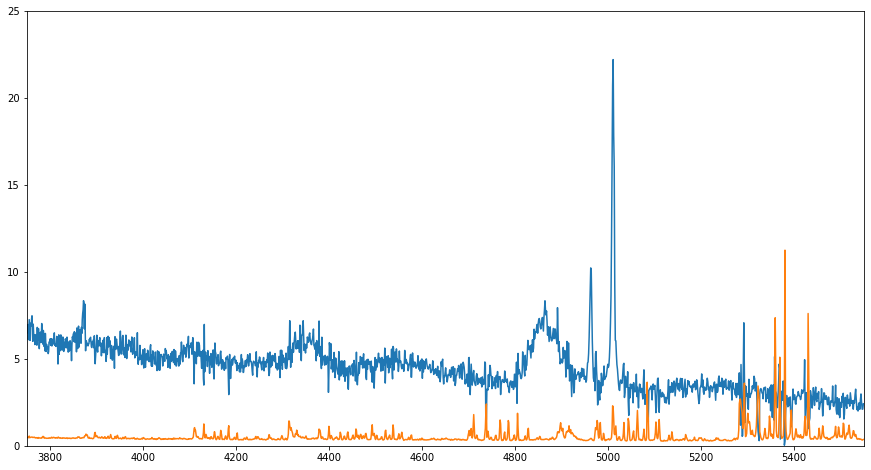

In [4]:
# load in example spectrum

data=np.load('./files/spec-9141-57663-0789_unred_z.npy',allow_pickle=True)
WL=data.item().get('WL')
INT=data.item().get('INT')
ERR=data.item().get('ERR')

# Initialize Spectral Decomposition Class
spec=SpecDecomp(WL,INT,ERR)

# clip data onto desired wavelength
minWL=3750       # minimum wavelength for fitting
maxWL=5550       # maximum wavelength for fitting
spec.clip_data_wavelength(minWL,maxWL)

plt.axis([minWL,maxWL,0,25])
plt.plot(spec.wave,spec.flux)
plt.plot(spec.wave,spec.err)

In [5]:
# Guess initial model parameters
spec.guess_initial_params()

# Fit Spectrum
spec.fit()

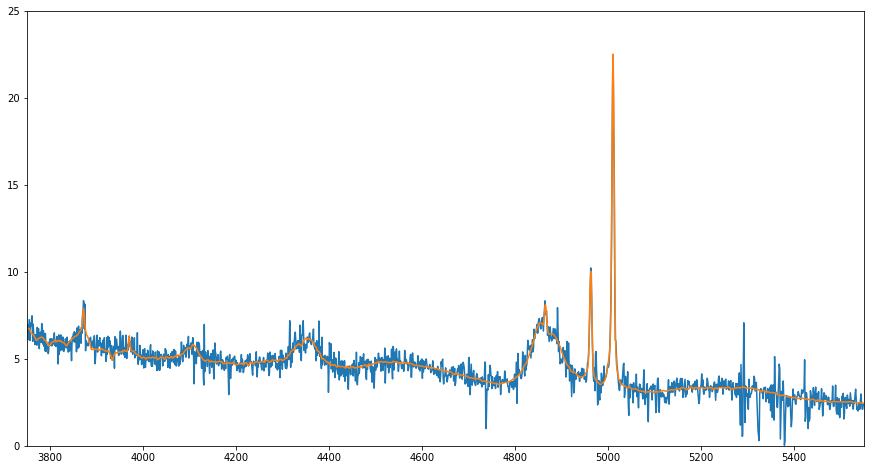

In [6]:
# Plot model and spectrum
model=spec.construct_model(spec.wave,spec.params_final,fit_type='full')

plt.axis([minWL,maxWL,0,25])
plt.plot(spec.wave,spec.flux)
plt.plot(spec.wave,model)

# Now we'll fit the same data with emcee

I'm following the emcee tutorial stuff here https://emcee.readthedocs.io/en/stable/tutorials/line/

In [7]:
nwalkers=200
nsteps=1000
# This is just an illustrative example, for a real run you would need to do many more steps


# Fit Spectrum with MCMC
spec.fit_emcee(nwalkers,nsteps)
sampler=spec.sampler

100%|██████████| 1000/1000 [01:48<00:00,  9.24it/s]


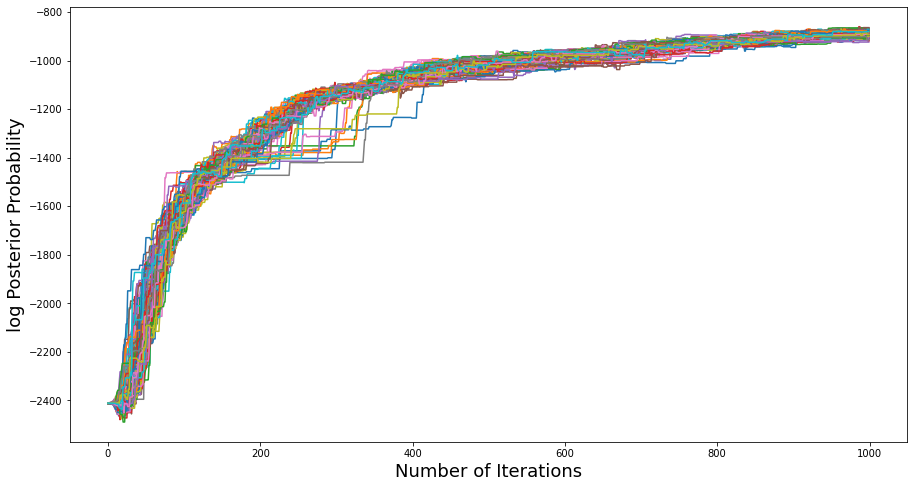

In [8]:
log_prob=sampler.get_log_prob()

plt.xlabel('Number of Iterations',fontsize=18)
plt.ylabel('log Posterior Probability',fontsize=18)
plt.plot(log_prob[:,:])
plt.show()

Text(0.5, 0, 'Walker')

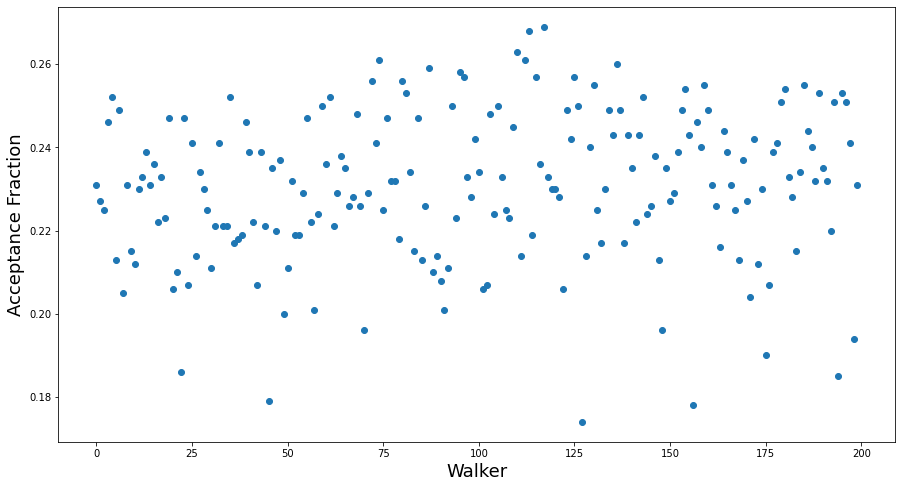

In [9]:
plt.scatter(np.arange(nwalkers),sampler.acceptance_fraction)
plt.ylabel('Acceptance Fraction',fontsize=18)
plt.xlabel('Walker',fontsize=18)

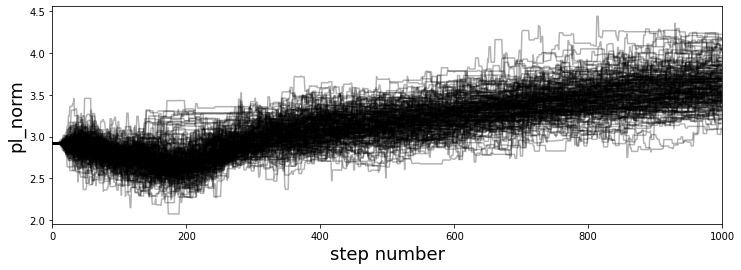

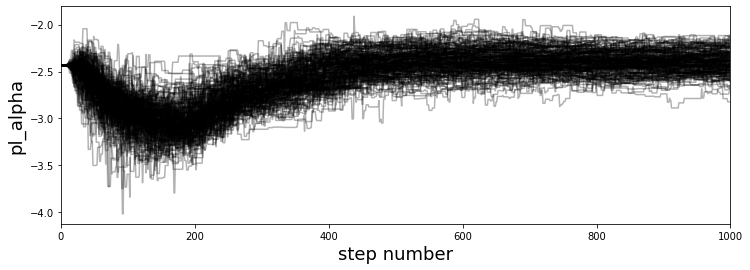

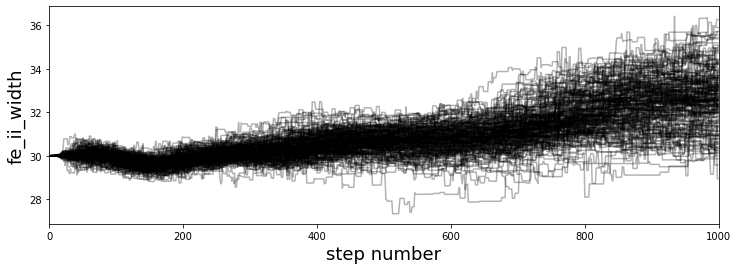

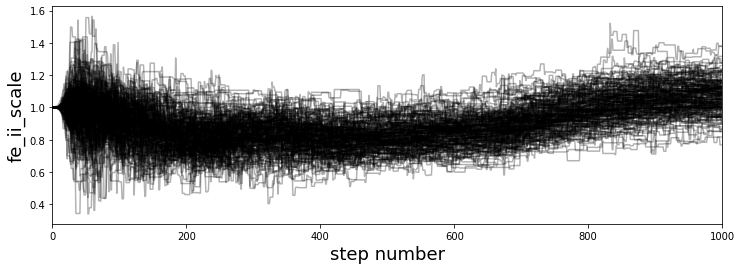

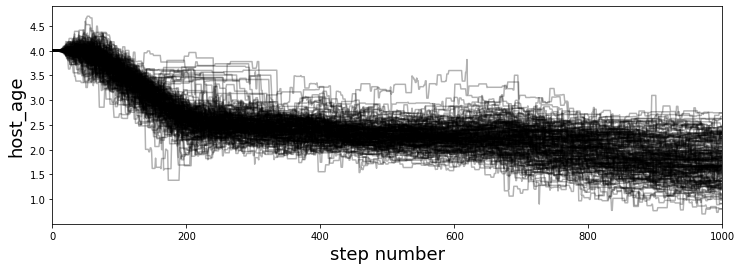

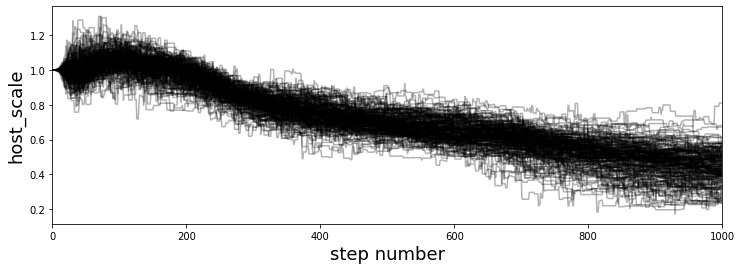

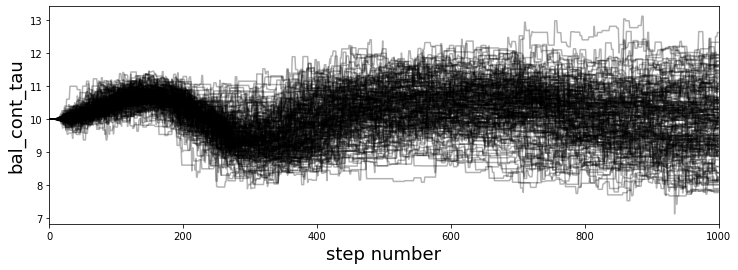

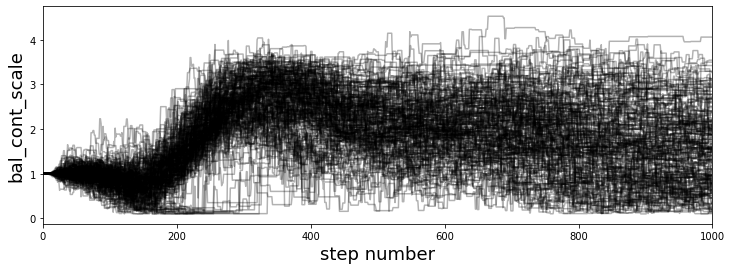

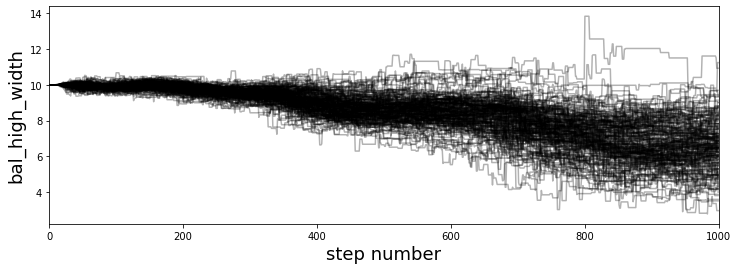

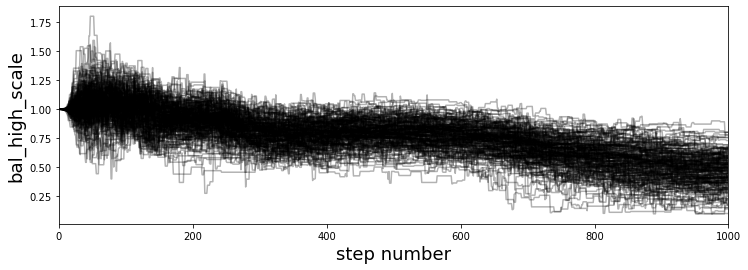

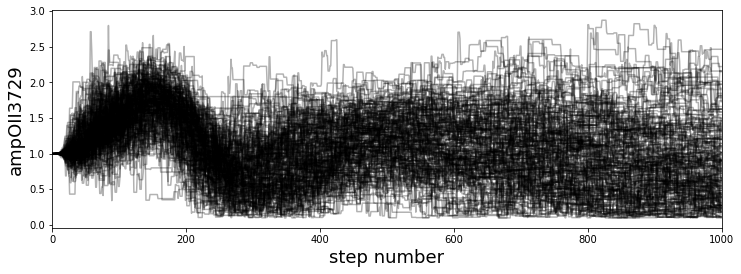

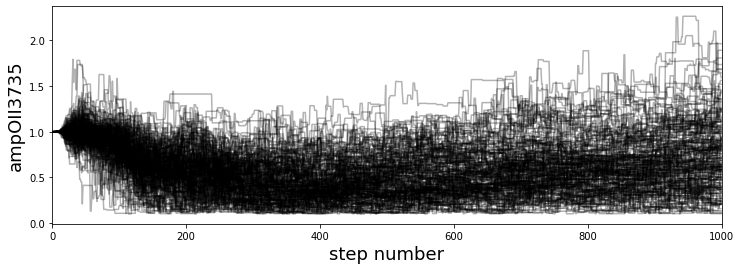

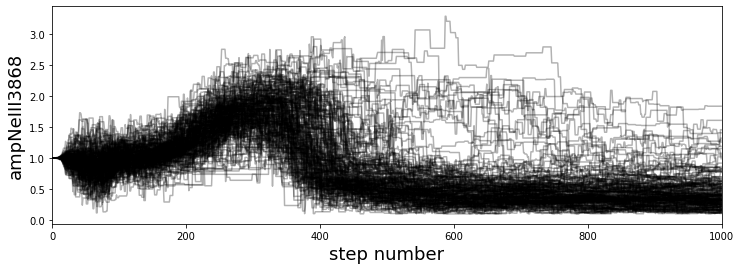

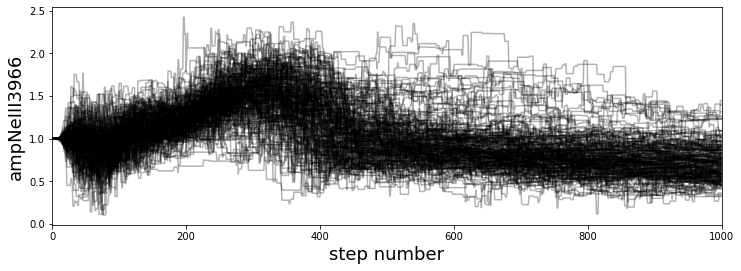

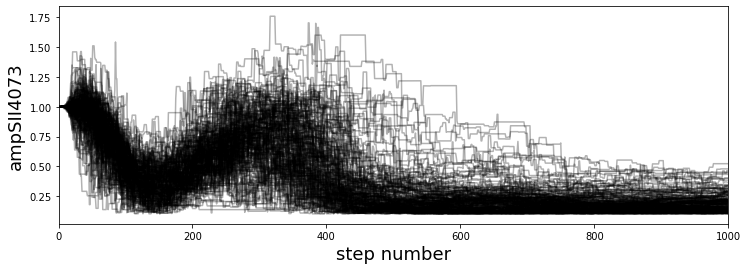

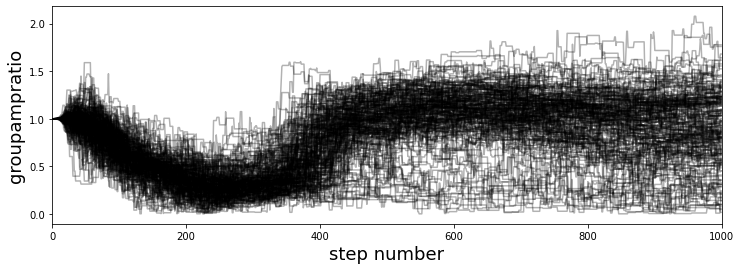

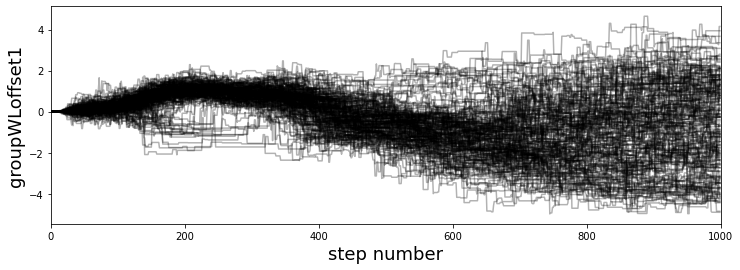

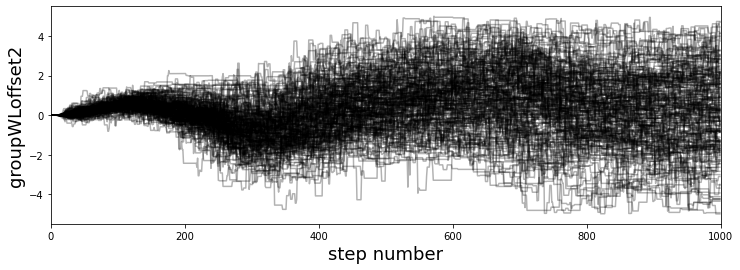

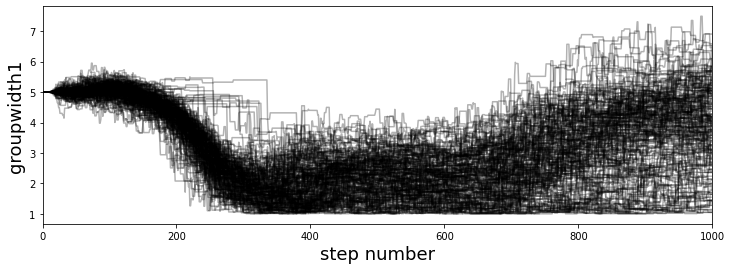

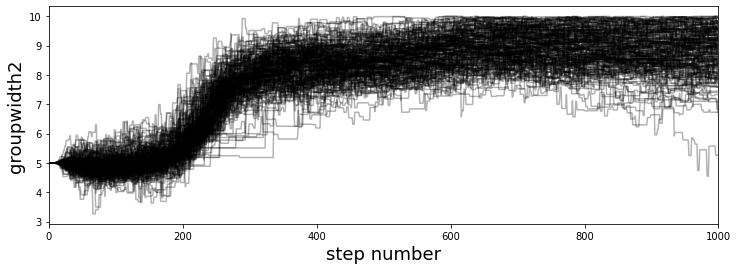

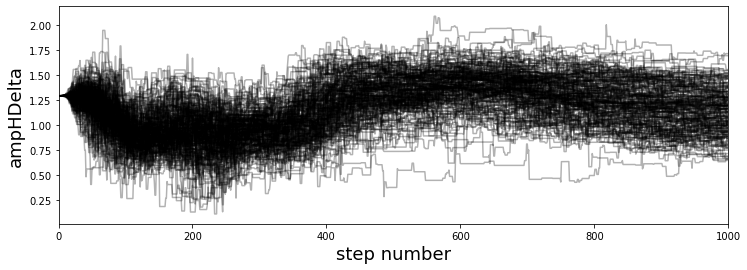

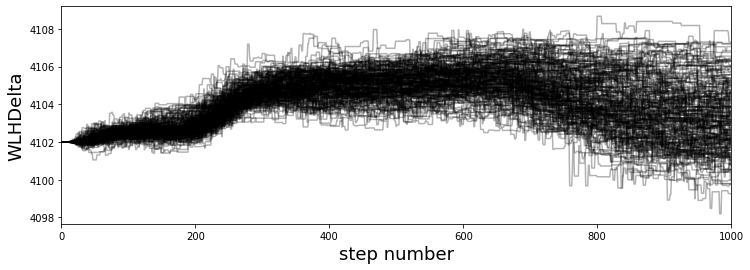

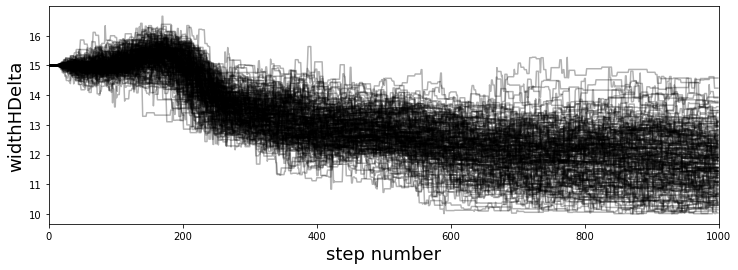

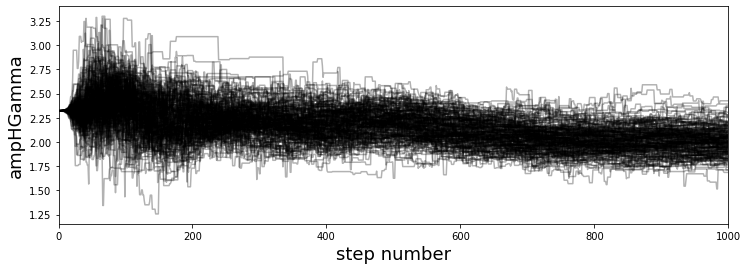

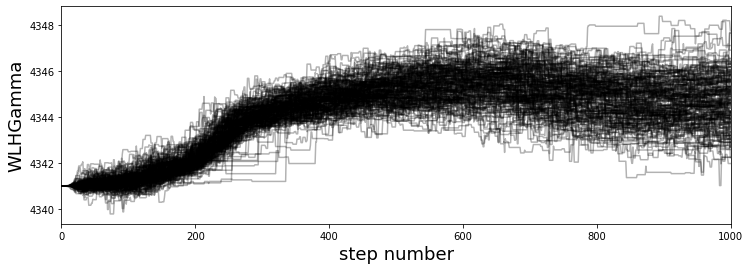

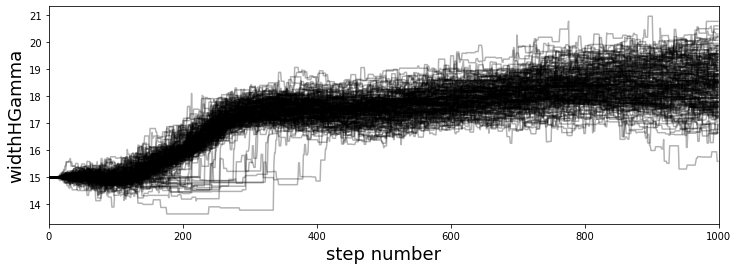

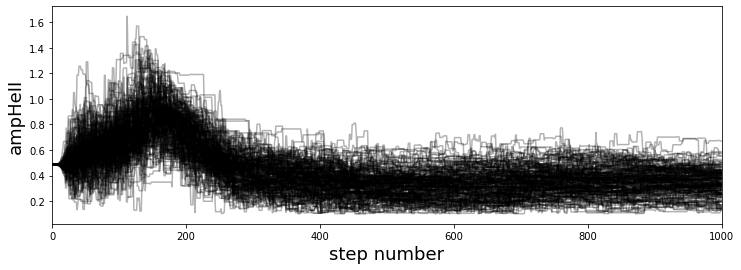

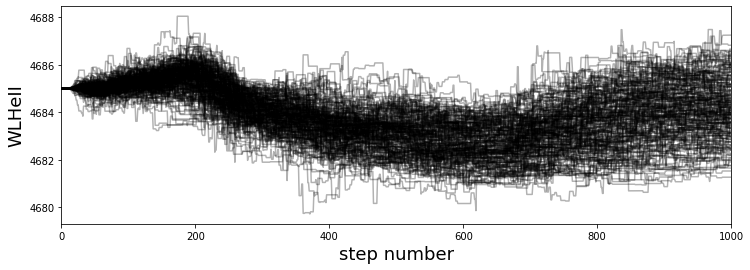

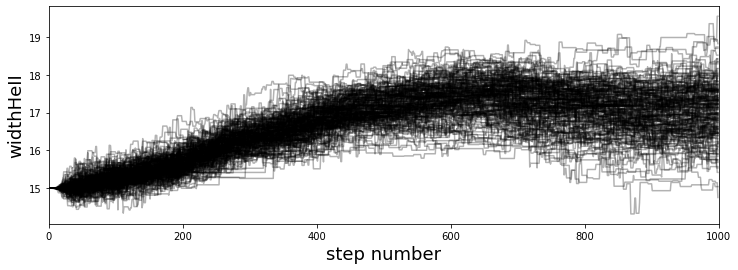

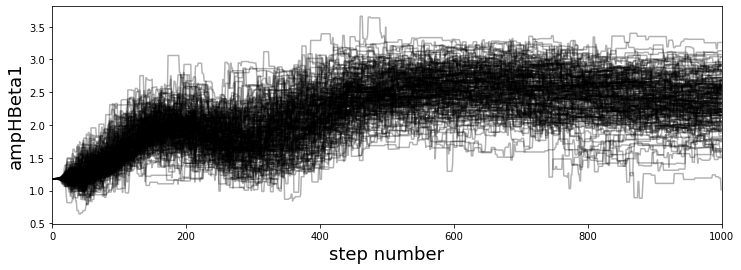

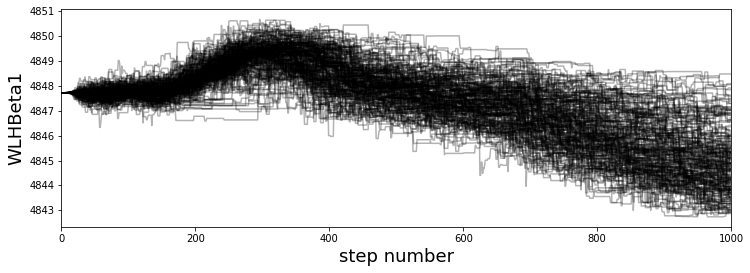

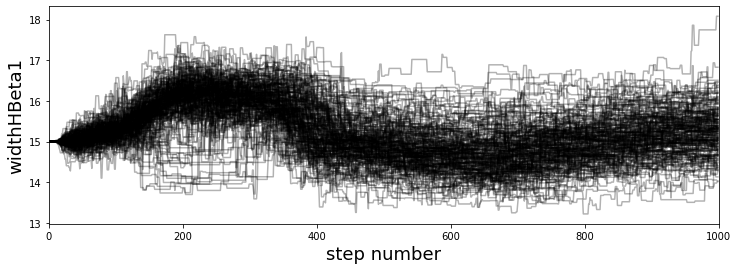

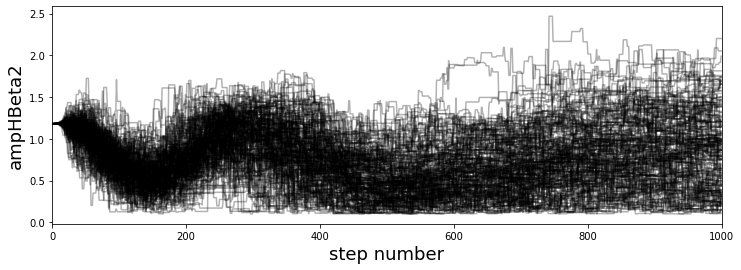

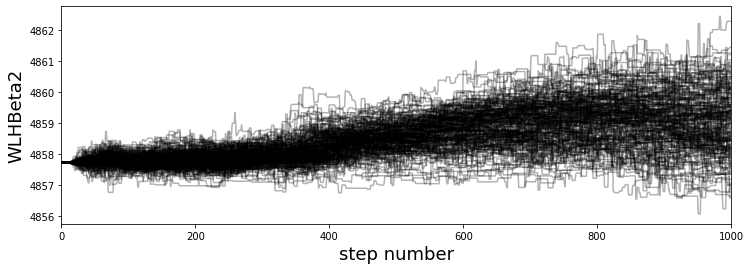

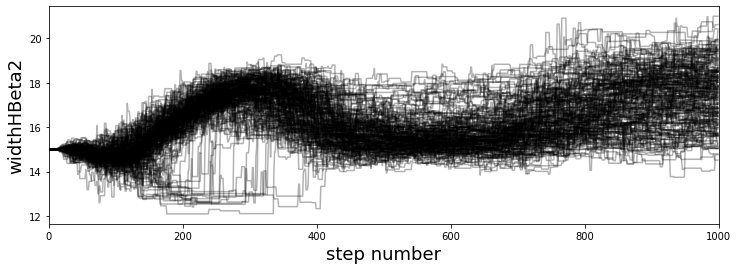

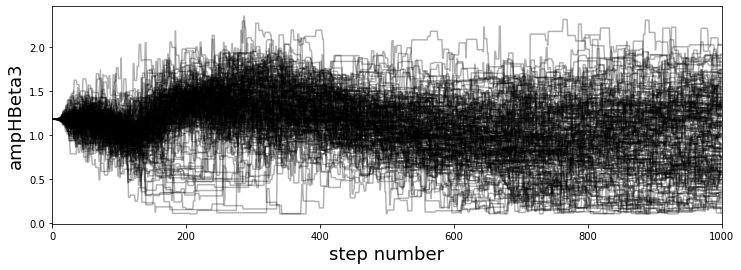

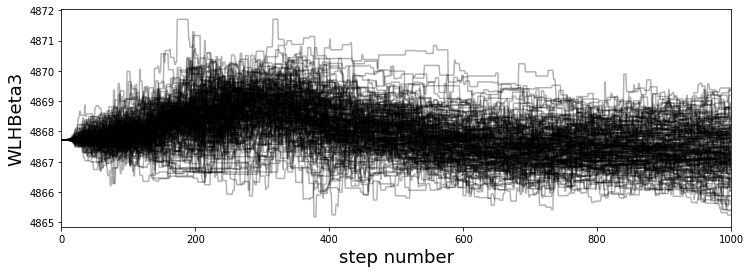

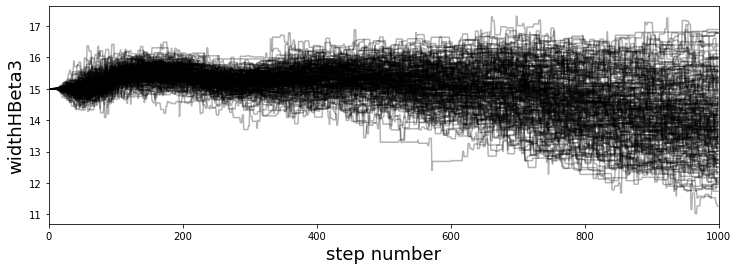

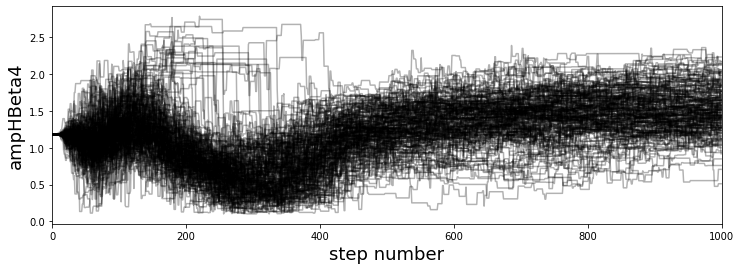

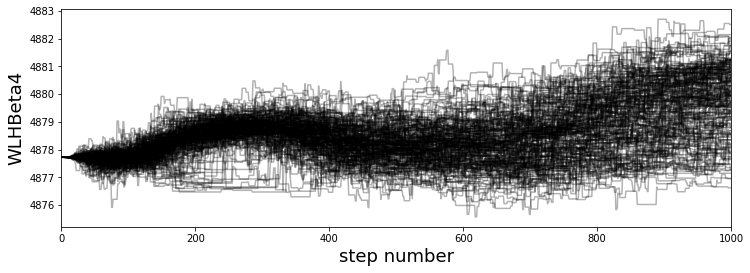

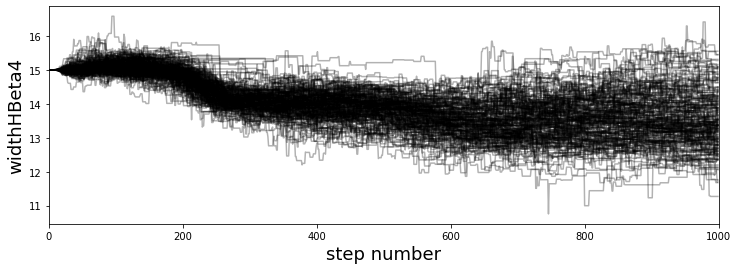

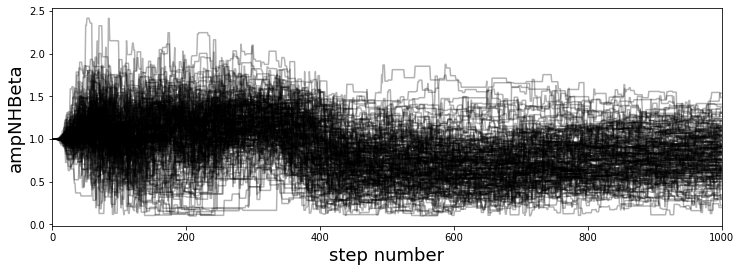

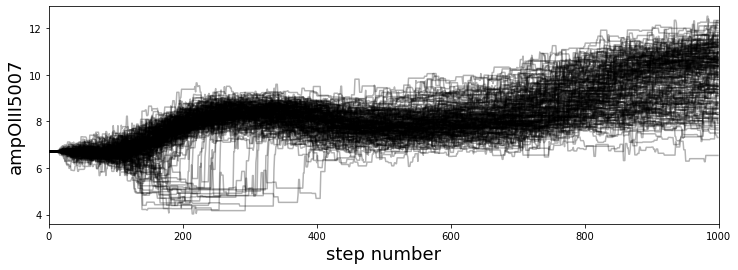

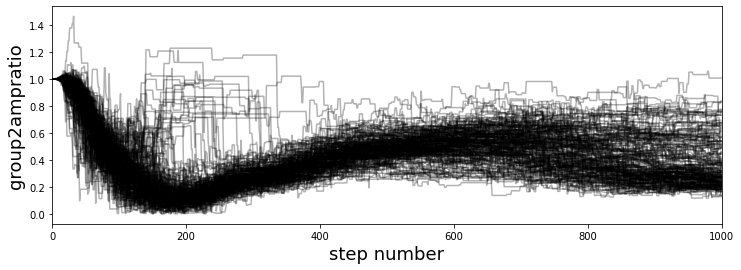

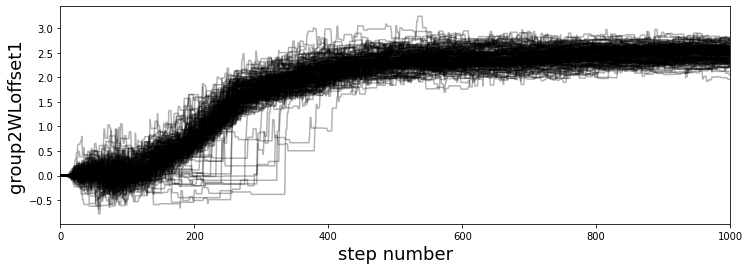

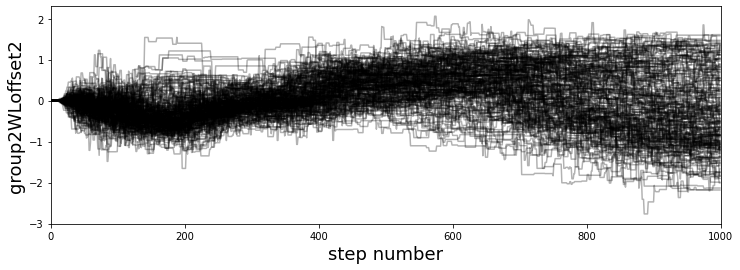

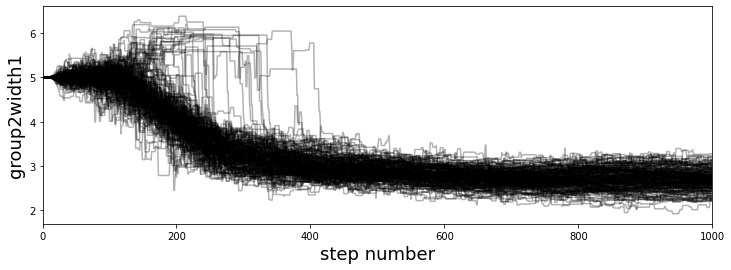

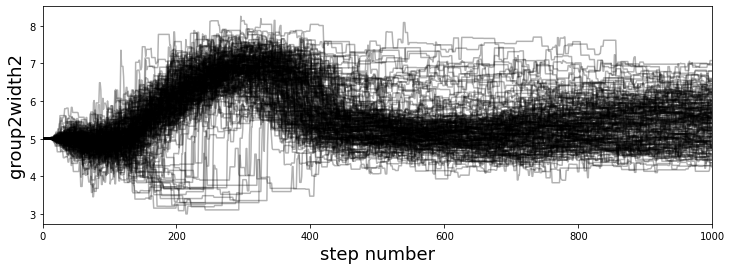

In [12]:
rcParams['figure.figsize'] = 12,4

samples = sampler.get_chain()
ndim=len(spec.params_keys)
for i in range(ndim):

    plt.plot(samples[:, :, i], "k", alpha=0.3)
    plt.xlim(0, len(samples))
    plt.ylabel(spec.params_keys[i],fontsize=18)
    plt.xlabel("step number",fontsize=18)
    plt.show()


In [13]:
# Now we decide a burnin and a thin value, then flatten the samples

#tau = sampler.get_autocorr_time()
#print('mean autocorrelation time '+str(np.average(tau)))


burnin=10
thin=15

flat_samples = sampler.get_chain(discard=burnin, thin=thin, flat=True)

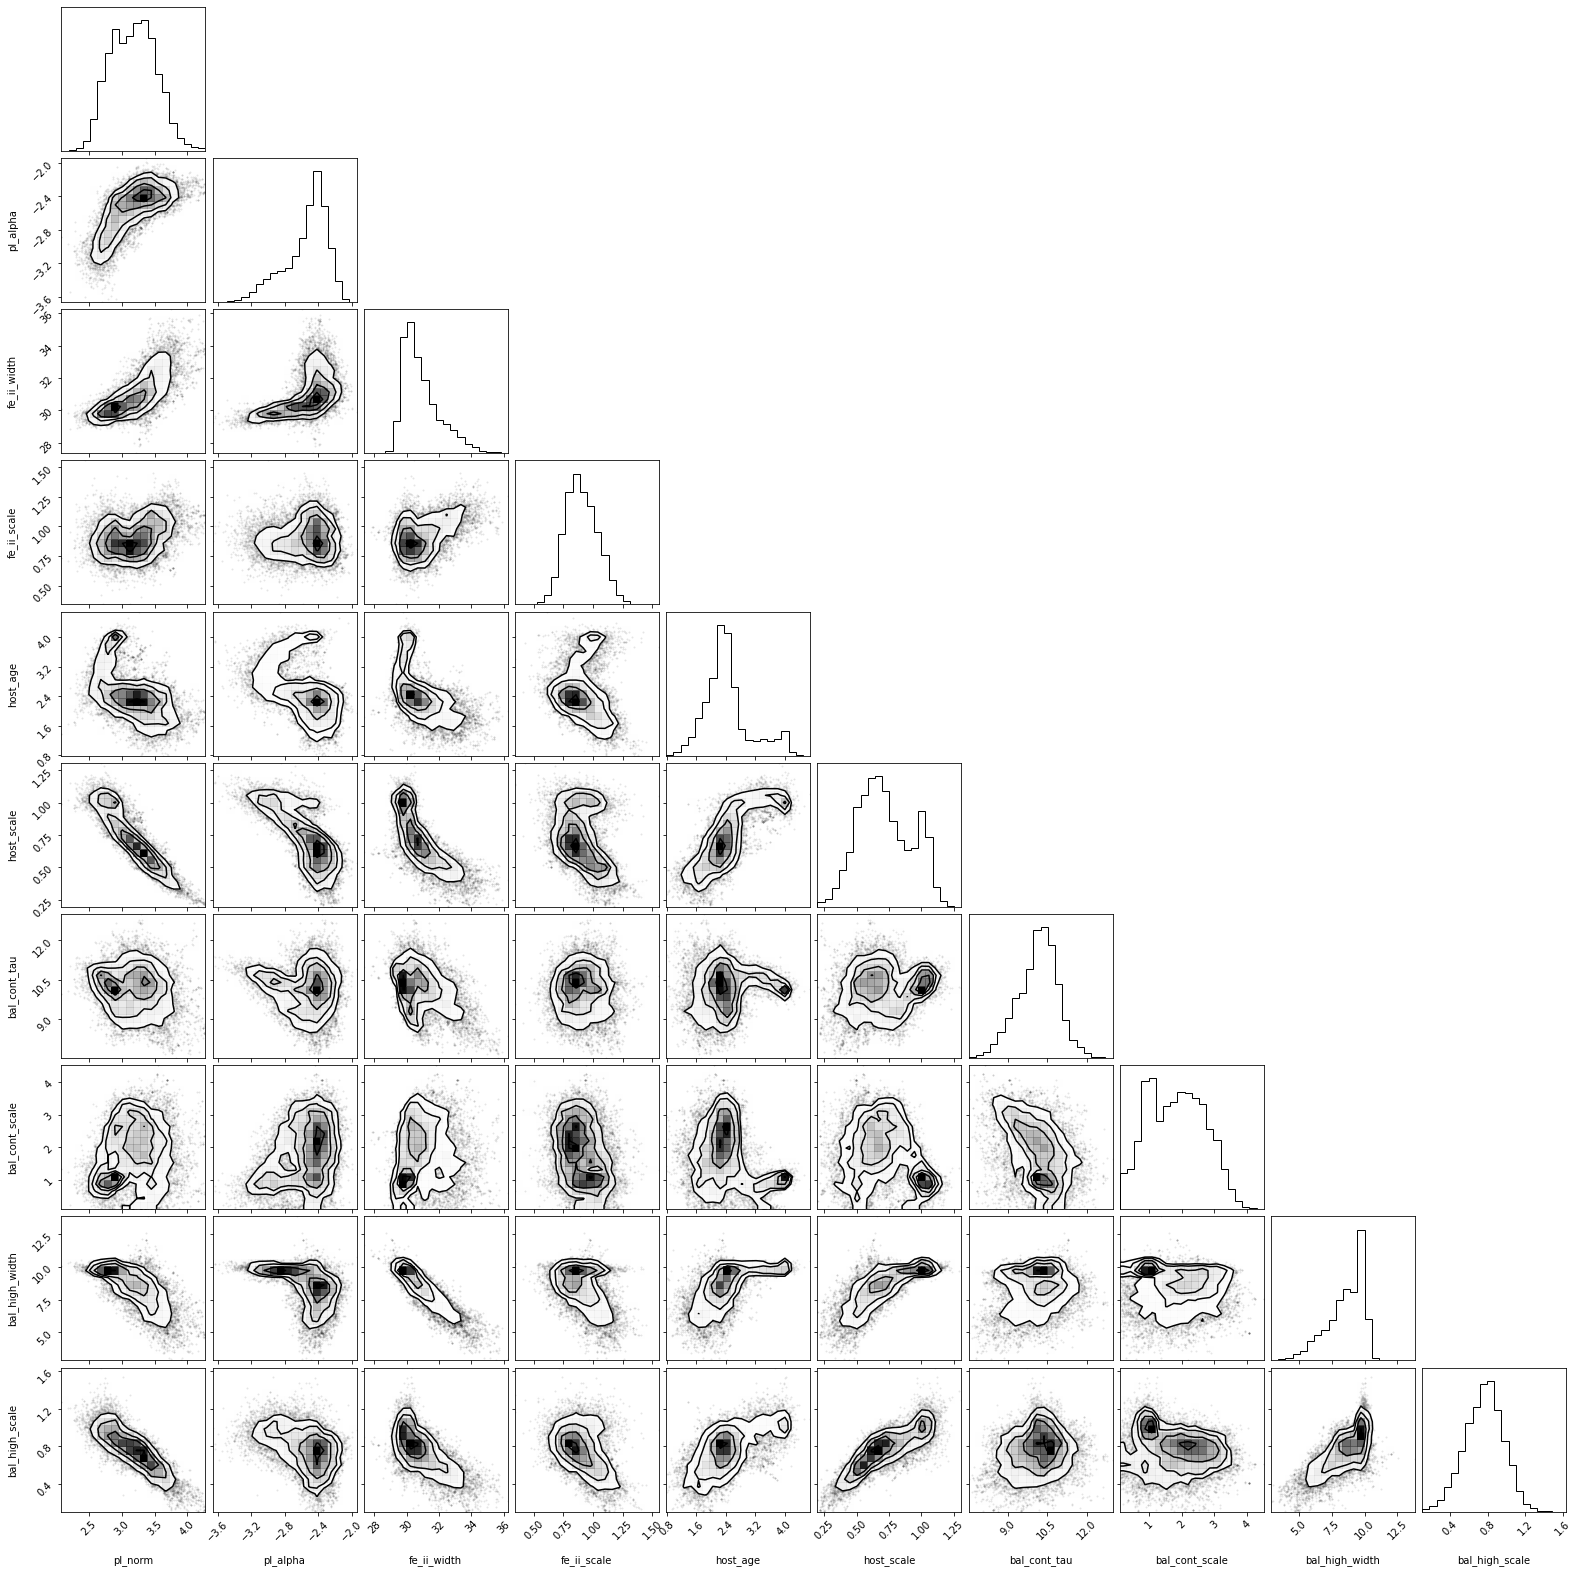

In [15]:
# we can make corner plots


fig = corner.corner(flat_samples[:,:10], labels=spec.params_keys[:10])

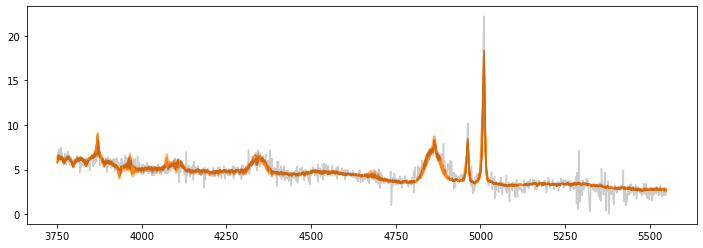

In [16]:
# Now we take some random samples of the converged chain and plot the model 

num_samples=20

inds = np.random.randint(len(flat_samples), size=num_samples)
for ind in inds:
    params = flat_samples[ind]
    plt.plot(spec.wave, spec.construct_model_emcee(params), "C1", alpha=0.5)
plt.plot(spec.wave, spec.flux, c='k',alpha=0.2)


# Now we can try turning off certain model parameters

/Users/dabbiecm/Documents/venv/lib/python3.8/site-packages/lmfit/minimizer.py:832: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))
/Users/dabbiecm/Documents/venv/lib/python3.8/site-packages/lmfit/minimizer.py:825: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])


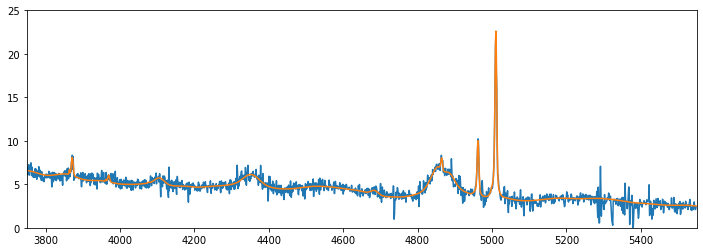

In [17]:
# Initialize Spectral Decomposition Class
spec=SpecDecomp(WL,INT,ERR)

# clip data onto desired wavelength
minWL=3750       # minimum wavelength for fitting
maxWL=5550       # maximum wavelength for fitting
spec.clip_data_wavelength(minWL,maxWL)

# Dictionary with booleans for whether to include certain model components
model_select={}
model_select['PowerLaw']=True
model_select['BalmerCont']=False
model_select['BalmerHigh']=False
model_select['FeII']=True
model_select['Host']=False
model_select['OII3729']=True
model_select['OII3735']=True
model_select['NeIII3868']=True
model_select['NeIII3966']=True
model_select['SII4073']=True
model_select['HDelta']=True
model_select['HGamma']=True
model_select['HeII']=True

spec.set_model(model_select)

# Guess initial model parameters
spec.guess_initial_params()

# Fit Spectrum
spec.fit()

# Plot model and spectrum
model=spec.construct_model(spec.wave,spec.params_final,fit_type='full')

plt.axis([minWL,maxWL,0,25])
plt.plot(spec.wave,spec.flux)
plt.plot(spec.wave,model)

In [18]:
# Notice no model terms for balmer and host galaxy
for key,value in spec.params_final.items():
    print(key)

pl_norm
pl_alpha
fe_ii_width
fe_ii_scale
ampOII3729
ampOII3735
ampNeIII3868
ampNeIII3966
ampSII4073
groupampratio
groupWLoffset1
groupWLoffset2
groupwidth1
groupwidth2
ampHDelta
WLHDelta
widthHDelta
ampHGamma
WLHGamma
widthHGamma
ampHeII
WLHeII
widthHeII
ampHBeta1
WLHBeta1
widthHBeta1
ampHBeta2
WLHBeta2
widthHBeta2
ampHBeta3
WLHBeta3
widthHBeta3
ampHBeta4
WLHBeta4
widthHBeta4
ampNHBeta
ampOIII5007
group2ampratio
group2WLoffset1
group2WLoffset2
group2width1
group2width2


# Now same for an emcee fit

In [19]:
# Initialize Spectral Decomposition Class
spec=SpecDecomp(WL,INT,ERR)

# clip data onto desired wavelength
minWL=3750       # minimum wavelength for fitting
maxWL=5550       # maximum wavelength for fitting
spec.clip_data_wavelength(minWL,maxWL)

# Dictionary with booleans for whether to include certain model components
model_select={}
model_select['PowerLaw']=True
model_select['BalmerCont']=False
model_select['BalmerHigh']=False
model_select['FeII']=True
model_select['Host']=False
model_select['OII3729']=True
model_select['OII3735']=True
model_select['NeIII3868']=True
model_select['NeIII3966']=True
model_select['SII4073']=True
model_select['HDelta']=True
model_select['HGamma']=True
model_select['HeII']=True

spec.set_model(model_select)

# Guess initial model parameters
spec.guess_initial_params()

# Fit Spectrum
nwalkers=200
nsteps=1000
# This is just an illustrative example, for a real run you would need to do many more steps

# Fit Spectrum with MCMC
spec.fit_emcee(nwalkers,nsteps)
sampler=spec.sampler


100%|██████████| 1000/1000 [01:31<00:00, 10.89it/s]


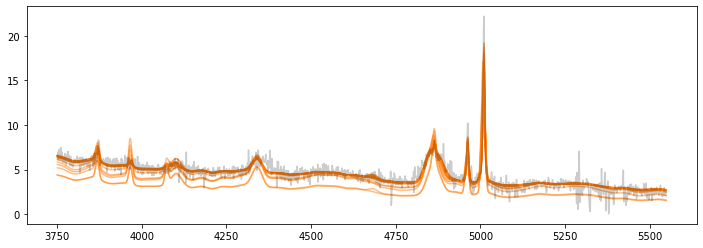

In [20]:
burnin=10
thin=15

flat_samples = sampler.get_chain(discard=burnin, thin=thin, flat=True)

num_samples=20

inds = np.random.randint(len(flat_samples), size=num_samples)
for ind in inds:
    params = flat_samples[ind]
    plt.plot(spec.wave, spec.construct_model_emcee(params), "C1", alpha=0.5)
plt.plot(spec.wave, spec.flux, c='k',alpha=0.2)

In [22]:
print(spec.params_keys)

['pl_norm', 'pl_alpha', 'fe_ii_width', 'fe_ii_scale', 'ampOII3729', 'ampOII3735', 'ampNeIII3868', 'ampNeIII3966', 'ampSII4073', 'groupampratio', 'groupWLoffset1', 'groupWLoffset2', 'groupwidth1', 'groupwidth2', 'ampHDelta', 'WLHDelta', 'widthHDelta', 'ampHGamma', 'WLHGamma', 'widthHGamma', 'ampHeII', 'WLHeII', 'widthHeII', 'ampHBeta1', 'WLHBeta1', 'widthHBeta1', 'ampHBeta2', 'WLHBeta2', 'widthHBeta2', 'ampHBeta3', 'WLHBeta3', 'widthHBeta3', 'ampHBeta4', 'WLHBeta4', 'widthHBeta4', 'ampNHBeta', 'ampOIII5007', 'group2ampratio', 'group2WLoffset1', 'group2WLoffset2', 'group2width1', 'group2width2']


# For plotting individual gaussians for emission lines

In [23]:
# Initialize Spectral Decomposition Class
spec=SpecDecomp(WL,INT,ERR)

# clip data onto desired wavelength
minWL=3750       # minimum wavelength for fitting
maxWL=5550       # maximum wavelength for fitting
spec.clip_data_wavelength(minWL,maxWL)

# Guess initial model parameters
spec.guess_initial_params()

# Fit Spectrum
spec.fit()

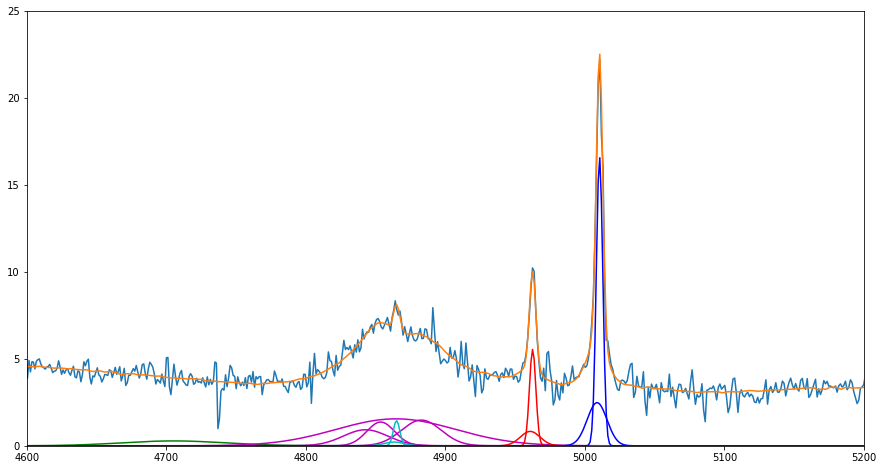

In [33]:
# Plot model and spectrum
model=spec.construct_model(spec.wave,spec.params_final,fit_type='full')

gaussians=spec.emission_lines(spec.wave,spec.params_final,return_gaussians=True)

#keys for gaussians are

# This fit tells me that I don't need He II
# should fit again with that component turned off

rcParams['figure.figsize'] = 15,8
plt.axis([4600,5200,0,25])
plt.plot(spec.wave,spec.flux)
plt.plot(spec.wave,gaussians['HeII'],c='g')
plt.plot(spec.wave,gaussians['HBeta_1'],c='m')
plt.plot(spec.wave,gaussians['HBeta_2'],c='m')
plt.plot(spec.wave,gaussians['HBeta_3'],c='m')
plt.plot(spec.wave,gaussians['HBeta_4'],c='m')
plt.plot(spec.wave,gaussians['NHBeta_1'],c='c')
plt.plot(spec.wave,gaussians['NHBeta_2'],c='c')
plt.plot(spec.wave,gaussians['OIII4960_1'],c='r')
plt.plot(spec.wave,gaussians['OIII4960_2'],c='r')
plt.plot(spec.wave,gaussians['OIII5007_1'],c='b')
plt.plot(spec.wave,gaussians['OIII5007_2'],c='b')
plt.plot(spec.wave,model)